<a href="https://colab.research.google.com/github/colinlovegood/modClass/blob/main/modulationClassifierReadt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт базовых библиотек

In [ ]:
# Импорт базовых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, time

# Импорт фреймворка для нейросетей
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



## Подключение к GoogleDrive

In [ ]:
# Запрос версии и подключение Google Drive
version = input("Введите номер версии: ")
from google.colab import drive
drive.mount('/content/drive')
project_folder = f"/content/drive/My Drive/radikModulationModel/{version}"
import os

os.makedirs(project_folder, exist_ok=True)

# Установка и настройка KaggleHub для загрузки датасета
!pip install kagglehub
import kagglehub
import os

dataset_path = "/content/drive/MyDrive/radikModulationModel/datasets"
dataset_name = "/content/drive/MyDrive/radikModulationModel/datasets/GOLD_XYZ_OSC.0001_1024.hdf5"


# Проверка наличия GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    gpu_details = tf.config.experimental.get_device_details(gpus[0])
    device_name = gpus[0].name
    print(f"Найден GPU: {device_name}, характеристика: {gpu_details.get('device_name')}")
else:
    print("GPU не найден, будет использоваться CPU")

# Проверка объёма доступной памяти (RAM)
import psutil
ram_gb = psutil.virtual_memory().total / (1024**3)
print(f"Доступно памяти: {ram_gb:.2f} GB")

Введите номер версии: 3
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Найден GPU: /physical_device:GPU:0, характеристика: Tesla T4
Доступно памяти: 12.67 GB


## Загрузка датасета

In [ ]:
import kagglehub
import shutil

h5_path = "/root/.cache/kagglehub/datasets/pinxau1000/radioml2018/versions/2/GOLD_XYZ_OSC.0001_1024.hdf5"

if not os.path.exists(h5_path):
    print("📥 Датасет не найден. Загружаем с KaggleHub...")

    # Скачиваем из KaggleHub
    path = kagglehub.dataset_download("pinxau1000/radioml2018")
    dataset_path = path
else:
    print("✅ Датасет уже существует по пути:", dataset_path)

✅ Датасет уже существует по пути: /content/drive/MyDrive/radikModulationModel/datasets


## Подготовка датасета

In [ ]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, Sequence

# Классы
class_labels = [
    "OOK", "4ASK", "8ASK", "BPSK", "QPSK", "8PSK", "16PSK", "32PSK",
    "16APSK", "32APSK", "64APSK", "128APSK", "16QAM", "32QAM", "64QAM", "128QAM", "256QAM",
    "GMSK", "OQPSK", "AM-SSB-WC", "AM-SSB-SC", "AM-DSB-SC", "FM", "AM-DSB-WC"
]

target_classes = ["BPSK", "QPSK", "OQPSK", "8PSK", "16QAM"]
target_indices = [class_labels.index(c) for c in target_classes]

# ===== Выбор нужных индексов и меток =====
with h5py.File(h5_path, 'r') as h5:
    Y_all = h5['Y'][:]
    total_indices = []
    total_labels = []
    for local_idx, global_idx in enumerate(target_indices):
        idx = np.where(Y_all[:, global_idx] == 1)[0]
        total_indices.extend(idx)
        total_labels.extend([local_idx] * len(idx))

    total_indices = np.array(total_indices)
    total_labels = np.array(total_labels)

# ===== Разделение на train/test =====
X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    total_indices, total_labels, test_size=0.2, stratify=total_labels, random_state=42
)

In [ ]:
class HDF5Generator(Sequence):
    def __init__(self, h5_path, indices, labels, batch_size=128, shuffle=True):
        self.h5_path = h5_path
        self.indices = np.array(indices)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            perm = np.random.permutation(len(self.indices))
            self.indices = self.indices[perm]
            self.labels = self.labels[perm]

    def __getitem__(self, idx):
      batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

      # Сортируем индексы
      sorted_idx = np.argsort(batch_idx)
      unsort_idx = np.argsort(sorted_idx)
      batch_idx_sorted = batch_idx[sorted_idx]

      with h5py.File(self.h5_path, 'r') as h5:
          X_batch = h5['X'][batch_idx_sorted].astype(np.float32)
          X_batch /= np.max(np.abs(X_batch), axis=(1, 2), keepdims=True)

      # Возвращаем в исходный порядок
      X_batch = X_batch[unsort_idx]
      y_batch = to_categorical(batch_labels, num_classes=len(target_classes))
      return X_batch, y_batch

## Создание и обучение модели

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3328/3328 ━━━━━━━━━━━━━━━━━━━━ 128s 37ms/step - accuracy: 0.5485 - loss: 0.9309 - val_accuracy: 0.6849 - val_loss: 0.6714
Epoch 2/20
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 121s 36ms/step - accuracy: 0.6992 - loss: 0.6457 - val_accuracy: 0.7292 - val_loss: 0.5631
Epoch 3/20
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 122s 37ms/step - accuracy: 0.7222 - loss: 0.5868 - val_accuracy: 0.7340 - val_loss: 0.5528
Epoch 4/20
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 122s 37ms/step - accuracy: 0.7311 - loss: 0.5653 - val_accuracy: 0.7375 - val_loss: 0.5412
Epoch 5/20
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 121s 36ms/step - accuracy: 0.7359 - loss: 0.5522 - val_accuracy: 0.7440 - val_loss: 0.5305
Epoch 6/20
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 120s 36ms/step - accuracy: 0.7413 - loss: 0.5422 - val_accuracy: 0.7377 - val_loss: 0.5418
Epoch 7/20
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 120s 36ms/step - accuracy: 0.7406 - loss: 0.5447 - val_accuracy: 0.7509 - val_loss: 0.5198
Epoch 8/20
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 121s 36ms/step - accuracy: 0.7473 - lo

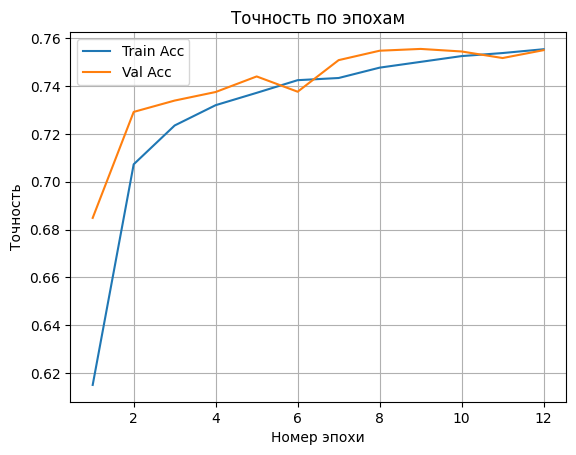

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.layers import BatchNormalization, LSTM
from tensorflow.keras.callbacks import Callback
import time
import pandas as pd
import matplotlib.pyplot as plt
import os

# ===== КОЛБЭК ДЛЯ ЛОГГИРОВАНИЯ ТОЧНОСТИ =====
class AccuracyLogger(Callback):
    def __init__(self):
        super().__init__()
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        self.history.append({
            'epoch': epoch + 1,
            'accuracy': logs.get('accuracy'),
            'val_accuracy': logs.get('val_accuracy')
        })

acc_logger = AccuracyLogger()

# ===== СОЗДАНИЕ МОДЕЛИ =====
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Input(shape=(1024, 2)),

    # --- Сверточные слои ---
    Conv1D(64, kernel_size=5, padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # --- Рекуррентный слой ---
    LSTM(64, return_sequences=False),

    # --- Полносвязные слои ---
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(target_classes), activation='softmax')
])


from tensorflow.keras.utils import plot_model

# Сохраняем изображение модели в файл PNG
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Колбэк: остановка, если валидационная точность не улучшается 5 эпох
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# ===== ОБУЧЕНИЕ С ЗАМЕРОМ ВРЕМЕНИ =====
start_time = time.time()

train_gen = HDF5Generator(h5_path, X_train_idx, y_train, batch_size=128)
test_gen = HDF5Generator(h5_path, X_test_idx, y_test, batch_size=128, shuffle=False)

with tf.device('/GPU:0'):
    history = model.fit(
        train_gen,
        epochs=20,
        validation_data=test_gen,
        callbacks=[acc_logger, early_stop]
    )

end_time = time.time()
print(f"\n⏱ Время обучения: {end_time - start_time:.2f} секунд")

# ===== ВЫВОД ТАБЛИЦЫ ТОЧНОСТИ =====
df_accuracy = pd.DataFrame(acc_logger.history)
print("\nТаблица точности по эпохам:")
print(df_accuracy)

# ===== ГРАФИК ТОЧНОСТИ =====
plt.plot(df_accuracy['epoch'], df_accuracy['accuracy'], label='Train Acc')
plt.plot(df_accuracy['epoch'], df_accuracy['val_accuracy'], label='Val Acc')
plt.xlabel('Номер эпохи')
plt.ylabel('Точность')
plt.title('Точность по эпохам')
plt.legend()
plt.grid(True)
plt.show()




## Оценка точночти

In [ ]:
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Test accuracy: 75.55%


<Figure size 800x600 with 0 Axes>

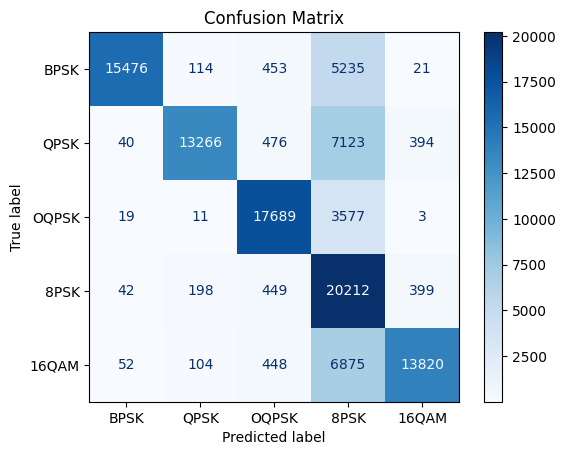

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Предсказания на генераторе
y_pred_probs = model.predict(test_gen, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Истинные метки (они уже есть в генераторе)
y_true = np.array(test_gen.labels)

# Матрица ошибок
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)

# Визуализация
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


,SNR (дБ),Accuracy
0,-20,0.200635
1,-18,0.205664
2,-16,0.208252
3,-14,0.222314
4,-12,0.252539
5,-10,0.327832
6,-8,0.430518
7,-6,0.572852
8,-4,0.627979
9,-2,0.737256


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128246 (\N{ANTENNA WITH BARS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


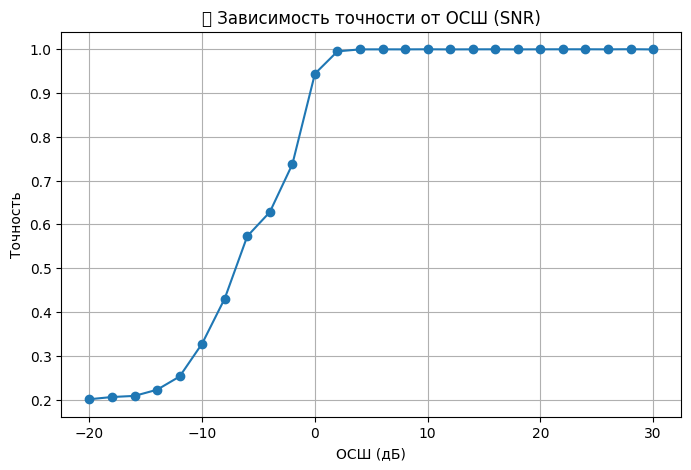

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
with h5py.File(h5_path, 'r') as h5:
    Z_all = h5['Z'][:]
snr_values = np.unique(Z_all)
snr_accuracy = {}

for snr in snr_values:
    # Получаем индексы по текущему SNR и целевым классам
    snr_indices = []
    snr_labels = []

    for local_idx, global_idx in enumerate(target_indices):
        indices = np.where((Z_all[:, 0] == snr) & (Y_all[:, global_idx] == 1))[0]
        snr_indices.extend(indices)
        snr_labels.extend([local_idx] * len(indices))

    if not snr_indices:
        continue

    snr_indices = np.array(snr_indices)
    snr_labels = np.array(snr_labels)

    # Сортировка индексов (обязательно для h5py)
    sort_idx = np.argsort(snr_indices)
    unsort_idx = np.argsort(sort_idx)  # если нужно восстановить порядок

    snr_indices_sorted = snr_indices[sort_idx]
    snr_labels_sorted = snr_labels[sort_idx]

    with h5py.File(h5_path, 'r') as h5:
        X_snr = h5['X'][snr_indices_sorted].astype(np.float32)
        X_snr = X_snr / np.max(np.abs(X_snr), axis=(1, 2), keepdims=True)

    # (необязательно) восстановить порядок
    X_snr = X_snr[unsort_idx]
    snr_labels = snr_labels_sorted[unsort_idx]



    # Предсказание
    y_pred = model.predict(X_snr, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = accuracy_score(snr_labels, y_pred_classes)
    snr_accuracy[snr] = acc

# Визуализация
snr_df = pd.DataFrame({
    "SNR (дБ)": list(snr_accuracy.keys()),
    "Accuracy": list(snr_accuracy.values())
}).sort_values("SNR (дБ)")

from IPython.display import display
display(snr_df)

plt.figure(figsize=(8, 5))
plt.plot(snr_df["SNR (дБ)"], snr_df["Accuracy"], marker='o')
plt.title("📶 Зависимость точности от ОСШ (SNR)")
plt.xlabel("ОСШ (дБ)")
plt.ylabel("Точность")
plt.grid(True)
plt.show()

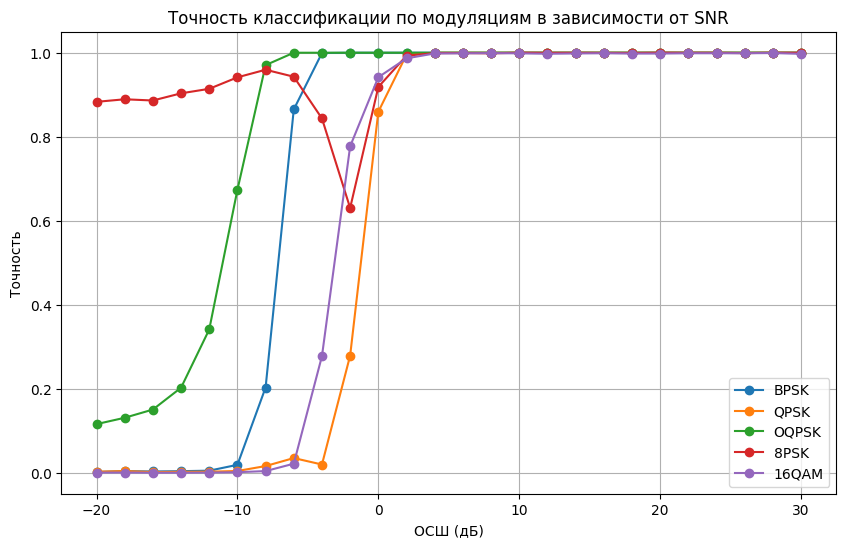

In [ ]:
# Словарь: {класс: [acc_snr0, acc_snr1, ...]}
class_snr_accuracy = {cls: [] for cls in range(len(target_classes))}

for snr in snr_values:
    with h5py.File(h5_path, 'r') as h5:
        Y_all = h5['Y'][:]
        Z_all = h5['Z'][:]

        snr_indices = []
        snr_labels = []

        for local_class_idx, global_class_idx in enumerate(target_indices):
            indices = np.where((Z_all[:, 0] == snr) & (Y_all[:, global_class_idx] == 1))[0]
            snr_indices.extend(indices)
            snr_labels.extend([local_class_idx] * len(indices))

        if not snr_indices:
            for cls in range(len(target_classes)):
                class_snr_accuracy[cls].append(np.nan)
            continue

        snr_indices = np.array(snr_indices)
        snr_labels = np.array(snr_labels)

        # ===== СОРТИРОВКА ДЛЯ h5py =====
        sort_idx = np.argsort(snr_indices)
        snr_indices_sorted = snr_indices[sort_idx]
        snr_labels_sorted = snr_labels[sort_idx]

        # Чтение из файла
        X_snr = h5['X'][snr_indices_sorted].astype(np.float32)
        X_snr /= np.max(np.abs(X_snr), axis=(1, 2), keepdims=True)

        # Возврат к исходному порядку (если важно)
        unsort_idx = np.argsort(sort_idx)
        X_snr = X_snr[unsort_idx]
        snr_labels = snr_labels_sorted[unsort_idx]

    # Предсказание
    y_pred = model.predict(X_snr, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    for cls in range(len(target_classes)):
        cls_indices = np.where(snr_labels == cls)[0]
        if len(cls_indices) == 0:
            class_snr_accuracy[cls].append(np.nan)
        else:
            acc = accuracy_score(snr_labels[cls_indices], y_pred_classes[cls_indices])
            class_snr_accuracy[cls].append(acc)

# ===== График точности по каждому классу =====
plt.figure(figsize=(10, 6))
for cls in range(len(target_classes)):
    plt.plot(snr_values, class_snr_accuracy[cls], label=target_classes[cls], marker='o')
plt.title("Точность классификации по модуляциям в зависимости от SNR")
plt.xlabel("ОСШ (дБ)")
plt.ylabel("Точность")
plt.grid(True)
plt.legend()
plt.show()

## Сохранение модели

In [ ]:
import os
models_folder = os.path.join(project_folder, "models")

# Создание папки, если не существует
os.makedirs(models_folder, exist_ok=True)

# Путь для сохранения модели
model_path = os.path.join(models_folder, "modulation_modelFinal75.h5")

# Сохранение модели
model.save(model_path)

print(f"Модель сохранена по пути: {model_path}")

Модель сохранена по пути: /content/drive/My Drive/radikModulationModel/3/models/modulation_modelFinal75.h5
